In [1]:
import tensorflow as tf
import numpy as np
import tensorflow.contrib.layers as layers

In [2]:
from sklearn.datasets import make_moons
from matplotlib import pyplot as plt
from flows import NVPFlow, FlowSequence, ResFlow, BNFlow, phase

In [3]:
inp = tf.placeholder(tf.float32, [None, 2])

In [4]:
flow = NVPFlow(2, 'init_flow', inp)

for i in range(0, 16):
    flow = NVPFlow(name='dense_' + str(i))(flow)
    flow = ResFlow(name='res_' + str(i))(flow)
    flow = BNFlow(name='bn_' + str(i))(flow)

In [5]:
flow[-1].output /= 8

In [6]:
flow[-1].logj.shape

TensorShape([])

In [7]:
flows = FlowSequence(flow[1:])

In [8]:
logj = flows.calc_logj()

In [9]:
logj

<tf.Tensor 'add_47:0' shape=(?,) dtype=float32>

In [10]:
mm = np.zeros(2, np.int)
for fl in flows:
    mm += fl.mask

In [11]:
mm

array([16, 16])

In [12]:
z = flows[-1].output
gain = tf.reduce_sum(-(z**2)/2, axis=-1) + logj
gain = tf.reduce_mean(gain)

In [13]:
z

<tf.Tensor 'truediv:0' shape=(?, 2) dtype=float32>

In [14]:
train_op = tf.train.AdamOptimizer(0.001).minimize(-gain)
train_op = [train_op] + flows.ops

In [15]:
X, _ = make_moons(n_samples=1024, noise=0.13)

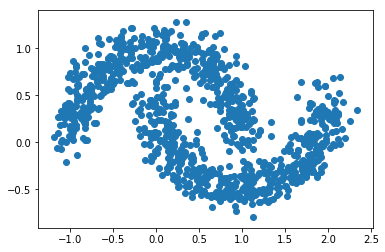

In [16]:
plt.scatter(X[:,0], X[:,1])
plt.show()

In [17]:
sess = tf.InteractiveSession()

In [18]:
tf.global_variables_initializer().run()

In [19]:
logj.eval({inp:X, phase: False}).mean()

12.94396

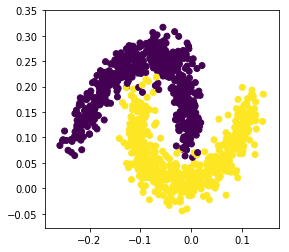

In [20]:
X, y = make_moons(n_samples=1024, noise=0.13)
ver = z.eval({inp:X})

ax = plt.gca()
ax.set_aspect('equal')
plt.scatter(ver[:,0], ver[:,1], c=y)
plt.show()

## If we replace ResFlow with NVPFlow:

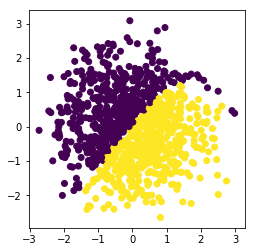

In [46]:
X, y = make_moons(n_samples=1024, noise=0.13)
ver = z.eval({inp:X})

ax = plt.gca()
ax.set_aspect('equal')
plt.scatter(ver[:,0], ver[:,1], c=y)
plt.show()

In [45]:
for _ in range(1000):
    for _ in range(1000):
        X, _ = make_moons(n_samples=256, noise=0.13)
        sess.run(train_op, {inp:X})
    print(gain.eval({inp:X}).mean())

-6.3982544
-6.3775606
-6.47264
-6.471692
-6.3993273
-6.437354
-6.3459015
-6.4307446
-6.462717
-6.413931
-6.4065228
-6.410662
-6.4966116
-6.401766
-6.4619856
-6.4606524
-6.468733
-6.3970537
-6.403159
-6.4229727
-6.407879
-6.4357686
-6.3994355
-6.323864
-6.325533
-6.391534
-6.45356
-6.393861
-6.4698544


KeyboardInterrupt: 

In [28]:
inverse = flows.apply(inp*8, inverse=True)

In [47]:
restored = inverse.eval({inp:np.random.normal(size=[400,2]), phase: False})
#restored = inverse.eval({inp:ver})

In [48]:
restored = restored[np.logical_not(np.any(restored**2 > 10, axis=-1))]

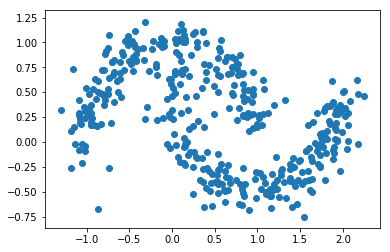

In [49]:
plt.scatter(restored[:,0], restored[:,1])
plt.show()

In [32]:
flows.ops

[]